# Network Science Final Project

In [1]:
import numpy as np
import scipy.io
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
mat = scipy.io.loadmat('./facebook-ego.mat')
A = mat['A']  #Adjacency matrix A
A = np.matrix(A)
G = nx.from_numpy_matrix(A) #Read graph

# Problem 1

In [3]:
def statisticalInfo(G):
    print(nx.info(G))
    print(f'Average clustering coefficient: {nx.algorithms.average_clustering(G)}')
    print(f'Diameter: {nx.algorithms.diameter(G)}')
    deg = G.degree()
    avg_degree = 0
    max_degree, min_degree = -1, 1e6
    for i in range(len(deg)):
        avg_degree += deg[i]
        max_degree = max(max_degree, deg[i])
        min_degree = min(min_degree, deg[i])
    print(f'Average degree: {avg_degree/len(deg)}')
    print(f'  Maximum degree: {max_degree}')
    print(f'  Minimum degree: {min_degree}')
    print(f'Density: {nx.classes.density(G)}')

In [4]:
# (a)
statisticalInfo(G)

Graph with 2851 nodes and 62318 edges
Average clustering coefficient: 0.5913760381733247
Diameter: 14
Average degree: 43.71659066994037
  Maximum degree: 769
  Minimum degree: 1
Density: 0.01533915462103171


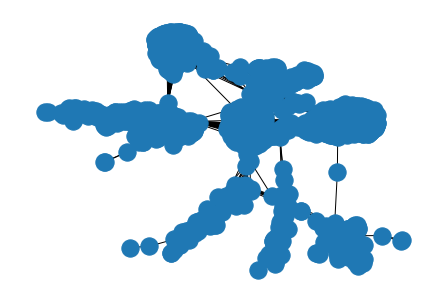

In [6]:
# (b)
nx.draw(G)
plt.draw()

Text(0, 0.5, 'Fraction pk of vertices with degree k (in logarithmic)')

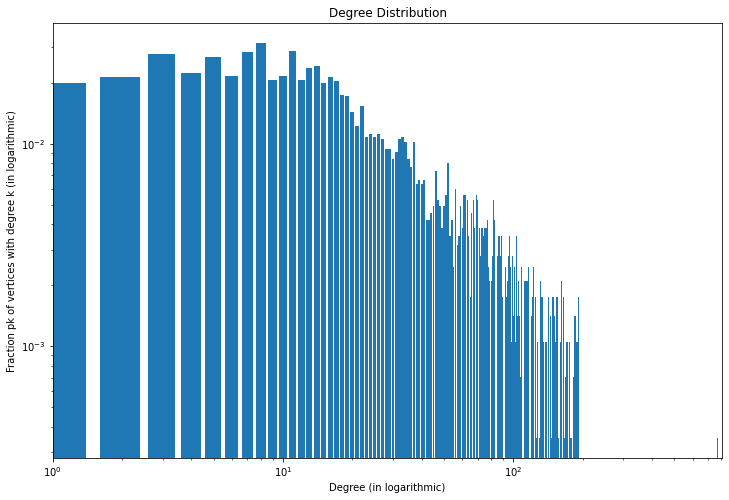

In [35]:
# (c)
hist = nx.degree_histogram(G)
plt.figure(figsize=(12, 8))
plt.bar(range(len(hist)), np.array(hist)/2851, log=True)
plt.xlim(left=1)
plt.xscale("log")
plt.title("Degree Distribution")
plt.xlabel('Degree (in logarithmic)')
plt.ylabel('Fraction pk of vertices with degree k (in logarithmic)')

In [114]:
# (d) Centrality
import networkx.algorithms.centrality as nx_cent
TOP = 10

def centrality(measure, G):
    dict = measure(G)
    if measure == nx_cent.voterank:
        n = G.number_of_nodes()
        for _ in range(n - len(dict)):
            idx = dict[0]
            while idx in dict:
                idx = np.random.randint(n)
            dict.append(idx)
        return dict
    np_array = np.array([v for v in dict.values()])
    return np.argsort(np_array)[::-1]
    
def output(top, name):
    print(f'{name}:\n\t', end='')
    for t in top:
        print(t, end=' ')

In [23]:
degree = centrality(nx_cent.degree_centrality, G)
output(degree[:TOP], 'Degree centrality')

Degree centrality:
	1165 91 0 1862 1681 1606 288 1341 1575 1298 

In [24]:
# Katz centrality
def random(k):
    a = np.random.rand()
    while a > 1/k:
        a = np.random.rand()
    return a

def Katz_centrality(A, iter=1000, beta=1):
    # alpha
    eigenvalues, _ = np.linalg.eig(A)
    k1 = np.max(eigenvalues)
    alpha = random(k1)

    # centrality
    x = np.zeros((A.shape[0], 1))
    for _ in range(iter):
        x = alpha * np.matmul(A, x) + beta

    x = np.array([np.array(x)[i][0] for i in range(len(x))])
    return np.argsort(x)[::-1]

In [26]:
katz = Katz_centrality(A, iter=5000) # from homework2
output(katz[:TOP], 'Katz centrality')

Katz centrality:
	1165 91 1862 1681 0 1606 1341 1575 1298 1493 

In [20]:
eigen = centrality(nx_cent.eigenvector_centrality, G)
output(eigen[:TOP], 'Eigenvector centrality')

Eigenvector centrality:
	1606 1551 1575 1790 1431 1561 1493 1741 1581 1349 

In [21]:
betweenness = centrality(nx_cent.betweenness_centrality, G)
output(betweenness[:TOP], 'Betweenness centrality')

Betweenness centrality:
	91 1165 0 1110 611 1056 771 892 1181 351 

In [25]:
closeness = centrality(nx_cent.closeness_centrality, G)
output(closeness[:TOP], 'Closeness centrality')

Closeness centrality:
	91 1165 1156 1086 933 1110 1181 1056 147 49 

# Problem 2

In [7]:
PHI = 0.1
NUM_S = 5
D = nx.algorithms.diameter(G)

In [8]:
def edge_removal(A, phi):
    '''Remove edges by the trick developed by Mollison and Grassberger
    Args:
        A: numpy.ndarray
            Adjacency matrix of the dataset
        phi: float
            prob. of the edge is present

    Returns:
        A_new: numpy.ndarray
            Adjacency matrix after edge removal
    '''
    P = np.triu(np.random.random_sample(A.shape),1)
    Prob = P+P.T
    A_new = ((A * Prob)> 1-phi).astype(int)
    return A_new

def node_removal(A, remove):
    '''Remove nodes
    Args:
        A: numpy.ndarray
            Adjacency matrix of the dataset
        remove: list
            list of node index to be removed

    Returns:
        A_new: numpy.ndarray
            Adjacency matrix after node removal
    '''
    A_new = A.copy()
    for rm in remove:
        for i in range(len(A)):
            A_new[i][rm] = 0
        for j in range(len(A)):
            A_new[rm][j] = 0
    return A_new

In [54]:
N = G.number_of_nodes()
rm_top = [int(N*0.1*i) for i in range(6)]
measure = [nx_cent.degree_centrality, Katz_centrality, nx_cent.eigenvector_centrality,
           nx_cent.betweenness_centrality, nx_cent.closeness_centrality]
R1 = {'Degree': np.zeros(6), 'Katz': np.zeros(6), 'Eigen': np.zeros(6),
       'Between': np.zeros(6), 'Close': np.zeros(6)}
log = {'Degree': np.zeros((6, 100)), 'Katz': np.zeros((6, 100)), 'Eigen': np.zeros((6, 100)),
       'Between': np.zeros((6, 100)), 'Close': np.zeros((6, 100))}

_iter = 100
for key, m in zip(R1.keys(), measure):
    print(f'[{key} centrality]')
    for i in range(len(rm_top)):
        r1 = 0
        for t in range(_iter):
            # step 1
            A_prime = edge_removal(np.array(A), PHI)
            G_prime = nx.from_numpy_matrix(A_prime)
            
            # step *
            top = Katz_centrality(A_prime) if m is Katz_centrality else centrality(m, G_prime)
            remove = top[:rm_top[i]]
            A_tilde = node_removal(A_prime, remove)

            # step 2
            n = G_prime.number_of_nodes()
            x = np.zeros((n, 1))
            x[np.random.randint(n, size=NUM_S)] = 1
            
            # step 3
            tmp = A_tilde + np.identity(A_tilde.shape[0])
            y = np.matmul(np.linalg.matrix_power(tmp, D), x)

            # step 4
            cnt = len(np.where(y>0)[0])
            
            r1 += cnt
            log[key][i][t] = cnt / n
            print(f'  Remove top-{rm_top[i]:<4d} | Iter[{t+1:3d}/100]: {(r1 / n) / (t + 1):.6f}', end='\r')

        print() 
        r1 = (r1 / n) / 100.0
        R1[key][i] = r1
    np.save(f'./log/log_{key}', log[key])

[Degree centrality]
  Remove top-0    | Iter[100/100]: 0.689032
  Remove top-285  | Iter[100/100]: 0.374749
  Remove top-570  | Iter[100/100]: 0.120698
  Remove top-855  | Iter[100/100]: 0.010463
  Remove top-1140 | Iter[100/100]: 0.002925
  Remove top-1425 | Iter[100/100]: 0.002066
[Katz centrality]
  Remove top-0    | Iter[100/100]: 0.687464
  Remove top-285  | Iter[100/100]: 0.435170
  Remove top-570  | Iter[100/100]: 0.157306
  Remove top-855  | Iter[100/100]: 0.026429
  Remove top-1140 | Iter[100/100]: 0.004037
  Remove top-1425 | Iter[100/100]: 0.002413
[Eigen centrality]
  Remove top-0    | Iter[100/100]: 0.689747
  Remove top-285  | Iter[100/100]: 0.548369
  Remove top-570  | Iter[100/100]: 0.339309
  Remove top-855  | Iter[100/100]: 0.186615
  Remove top-1140 | Iter[100/100]: 0.072929
  Remove top-1425 | Iter[100/100]: 0.027938
[Between centrality]
  Remove top-0    | Iter[100/100]: 0.695184
  Remove top-285  | Iter[100/100]: 0.226962
  Remove top-570  | Iter[100/100]: 0.09494

## Experiment result
|Measure    |0%|10%|20%|30%|40%|50%|
|:---------:|:----|:----|:----|:----|:----|:----|
|Degree     |0.689032|0.374749|0.120698|<B>0.010463</B>|<B>0.002925</B>|<B>0.002066</B>|
|Katz       |<B>0.687464</B>|0.435170|0.157306|0.026429|0.004037|0.002413|
|Eigenvector|0.689747|0.548369|0.339309|0.186615|0.072929|0.027938|
|Betweenness|0.695184|<B>0.226962</B>|<B>0.094949</B>|0.039646|0.011122|0.002434|
|Closeness  |0.693094|0.339548|0.200284|0.110716|0.047341|0.022210|

## Other centrality measure
* `PageRank`
* `VoteRank`
* `Harmonic centrality`

In [120]:
N = G.number_of_nodes()
rm_top = [int(N*0.1*i) for i in range(6)]
measure = [nx.pagerank, nx_cent.voterank, nx_cent.harmonic_centrality]
R1 = {'PageRank': np.zeros(6), 'VoteRank': np.zeros(6), 'Harmonic': np.zeros(6)}
log = {'PageRank': np.zeros((6, 100)), 'VoteRank': np.zeros((6, 100)), 'Harmonic': np.zeros((6, 100))}

_iter = 100
for key, m in zip(R1.keys(), measure):
    print(f'[{key} centrality]')
    for i in range(len(rm_top)):
        r1 = 0
        for t in range(_iter):
            # step 1
            A_prime = edge_removal(np.array(A), PHI)
            G_prime = nx.from_numpy_matrix(A_prime)
            
            # step *
            top = Katz_centrality(A_prime) if m is Katz_centrality else centrality(m, G_prime)
            remove = top[:rm_top[i]]
            A_tilde = node_removal(A_prime, remove)

            # step 2
            n = G_prime.number_of_nodes()
            x = np.zeros((n, 1))
            x[np.random.randint(n, size=NUM_S)] = 1
            
            # step 3
            tmp = A_tilde + np.identity(A_tilde.shape[0])
            y = np.matmul(np.linalg.matrix_power(tmp, D), x)

            # step 4
            cnt = len(np.where(y>0)[0])
            
            r1 += cnt
            log[key][i][t] = cnt / n
            print(f'  Remove top-{rm_top[i]:<4d} | Iter[{t+1:3d}/100]: {(r1 / n) / (t + 1):.6f}', end='\r')

        print() 
        r1 = (r1 / n) / 100.0
        R1[key][i] = r1
    np.save(f'./log/log_{key}', log[key])
    np.save(f'./log/R1_{key}', R1[key])

[PageRank centrality]
  Remove top-0    | Iter[100/100]: 0.689937
  Remove top-285  | Iter[100/100]: 0.276692
  Remove top-570  | Iter[100/100]: 0.084177
  Remove top-855  | Iter[100/100]: 0.015167
  Remove top-1140 | Iter[100/100]: 0.004504
  Remove top-1425 | Iter[100/100]: 0.001884
[VoteRank centrality]
  Remove top-0    | Iter[100/100]: 0.688888
  Remove top-285  | Iter[100/100]: 0.280277
  Remove top-570  | Iter[100/100]: 0.086461
  Remove top-855  | Iter[100/100]: 0.040621
  Remove top-1140 | Iter[100/100]: 0.008362
  Remove top-1425 | Iter[100/100]: 0.009404
[Harmonic centrality]
  Remove top-0    | Iter[100/100]: 0.694942
  Remove top-285  | Iter[100/100]: 0.333560
  Remove top-570  | Iter[100/100]: 0.176552
  Remove top-855  | Iter[100/100]: 0.092083
  Remove top-1140 | Iter[100/100]: 0.033385
  Remove top-1425 | Iter[100/100]: 0.018622


## Visualize

### Utils

In [122]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [130]:
def boxplot(log, r1, label, alpha=-0.45, beta=0.13):
    if len(label) == 5:
        color = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
    else:
        color = ['#999999', '#a65628', '#f781bf']

    box_width = 0.1
    x_ticks = ['0%', '10%', '20%', '30%', '40%', '50%']
    y_ticks = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%']

    plt.figure(figsize=(10, 6))

    for i in range(len(log)):
        shift = alpha + i * beta
        bp = plt.boxplot(log[i], positions=np.array(range(len(log[i]))) + shift, sym='', widths=box_width)
        set_box_color(bp, color[i])
        plt.plot(np.array(range(0, len(x_ticks))) + shift, r1[i],
                    marker="o", c=color[i], label=label[i])

    plt.legend()
    plt.xlabel('percentage  of nodes removed')
    plt.ylabel('prevalence rate r1')

    plt.xticks(range(0, len(x_ticks)), x_ticks)
    plt.yticks(range(0, 71, 10), y_ticks)

    plt.xlim(-1, len(x_ticks))
    plt.tight_layout()

### Plot

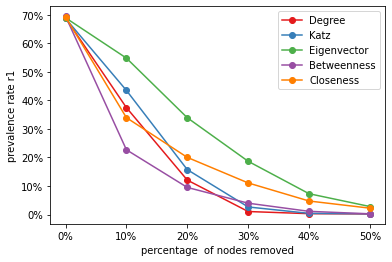

In [140]:
label = ['Degree', 'Katz', 'Eigenvector', 'Betweenness', 'Closeness']
color = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

for i, key in enumerate(R1.keys()):
    plt.plot(R1[key] * 100, marker='o', label=label[i], c=color[i])
plt.xlabel('percentage  of nodes removed')
plt.ylabel('prevalence rate r1')
plt.xticks(range(6), ['0%', '10%', '20%', '30%', '40%', '50%'])
plt.yticks(range(0, 71, 10), ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])
plt.legend()
plt.show()

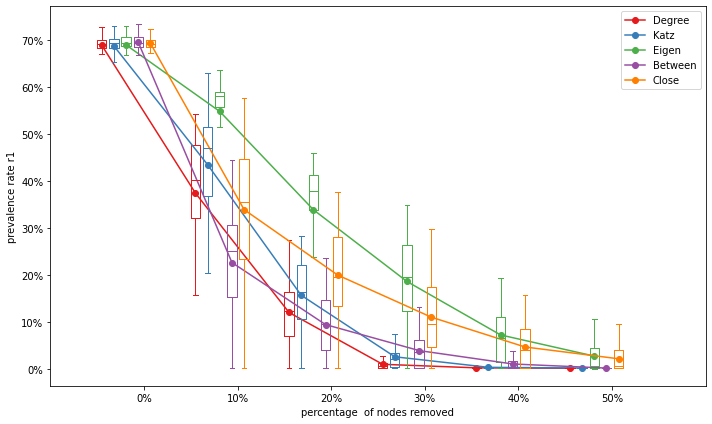

In [135]:
key_names = ['Degree', 'Katz', 'Eigen', 'Between', 'Close']
log_his = []
r1_his = []
for k in key_names:
    tmp = np.load(f'./log/log_{k}.npy')
    log_his.append((tmp * 100).tolist())
    tmp = np.load(f'./log/r1_{k}.npy')
    r1_his.append((tmp * 100).tolist())

boxplot(log_his, r1_his, key_names)

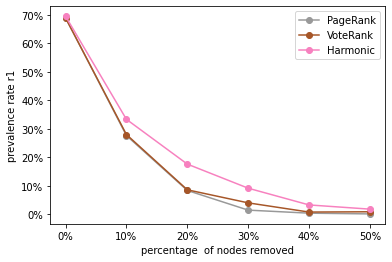

In [127]:
label = ['PageRank', 'VoteRank', 'Harmonic']
color = ['#999999', '#a65628', '#f781bf']

for i, key in enumerate(R1.keys()):
    plt.plot(R1[key] * 100, marker='o', label=label[i], c=color[i])
plt.xlabel('percentage  of nodes removed')
plt.ylabel('prevalence rate r1')
plt.xticks(range(6),
 ['0%', '10%', '20%', '30%', '40%', '50%'])
plt.yticks(range(0, 71, 10), ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])
plt.legend()
plt.show()

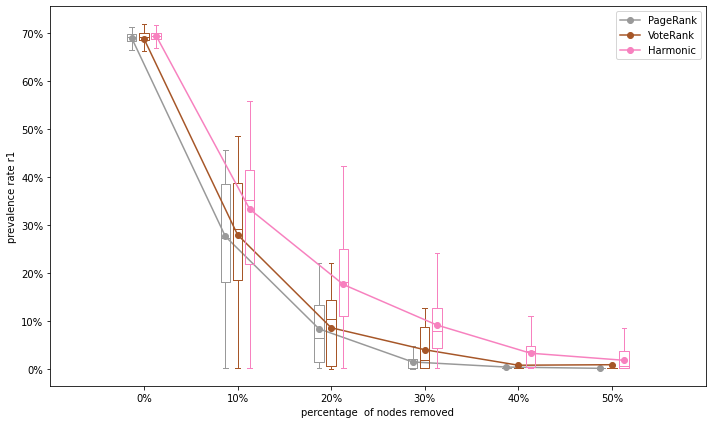

In [133]:
key_names = ['PageRank', 'VoteRank', 'Harmonic']
log_his = []
r1_his = []
for k in key_names:
    tmp = np.load(f'./log/log_{k}.npy')
    log_his.append((tmp * 100).tolist())
    tmp = np.load(f'./log/r1_{k}.npy')
    r1_his.append((tmp * 100).tolist())

boxplot(log_his, r1_his, key_names, alpha=-0.13, beta=0.13)